# Statistical Pattern Recognition Exercise 5: Regression

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# get the default color cycle from matplotlib
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
def get_color(i):
    return color_cycle[i % len(color_cycle)]

## $\star$ Part 1: Linear Regression with polynomials

### Part 1.1: Load and plot data

Load the points from `regression.npz`.

The data contains $N$ datapoints and 2 columns with column 0 as x-axis (inputs $\mathbf{x}$) and feature 1 as y-axis (targets $\mathbf{t}$). Scatterplot the data.


In [6]:
# START TODO ################
# Load the data and print the shape
data = np.load('../data/regression.npz')["arr_0"]
print(data.shape)
# END TODO ################


(20, 2)


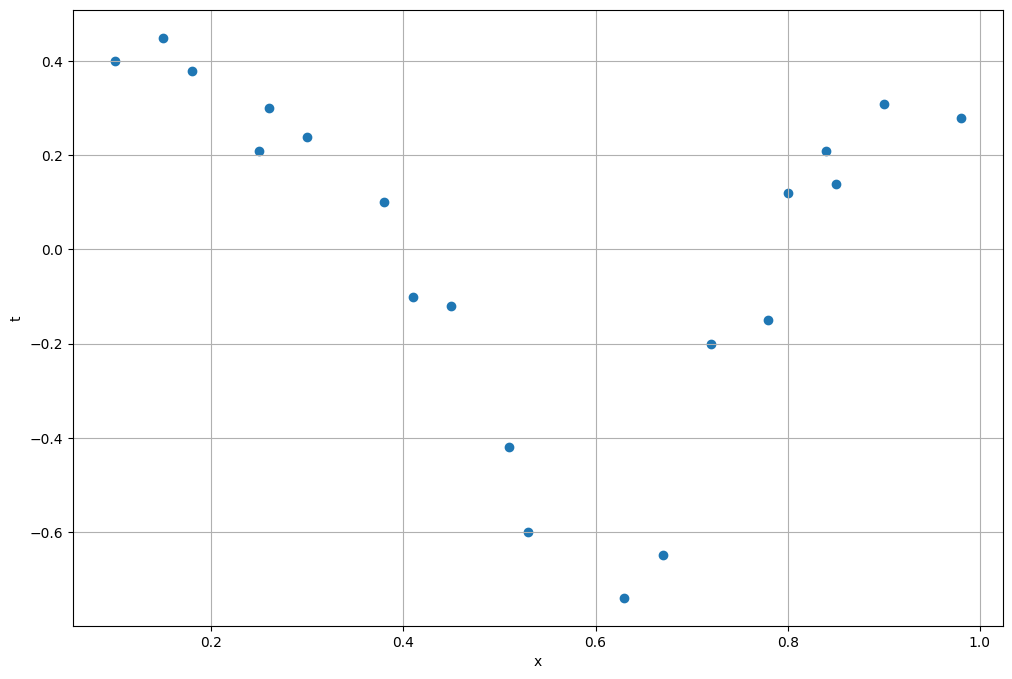

In [7]:
# START TODO ################
# Scatterplot the data. 
# As usual feature 0 is the x-axis and feature 1 is the y-axis.
x = data[:, 0]
t = data[:, 1]

plt.figure(figsize=(12,8))
plt.scatter(x, t,)
plt.xlabel("x")
plt.ylabel("t")
plt.grid()
plt.show()
# END TODO ################


### Part 1.2: Implementation

Now the goal is to estimate the weight parameters using $m^{\textrm{th}}$ order polynomials as basis functions using the ML Estimator.

Implement function `get_poly_features` - Get the polynomial features given inputs $\mathbf{x}$ and polynomial degree $m$. Compute the $M = m + 1$ basis functions with $\phi_m(x_n) = x_n ^ m $ for $m = \{0, ..., M\}$ and $n = \{0, ..., N-1\}$. Return a matrix $\Phi$ of shape $(N, M+1)$.

Implement a predictor class with the following functions:

1. `fit` - Estimate and save the weight parameters using the ML estimator. Hint: `np.linalg.inv` can inverse matrices.
1. `predict` - Predict targets given inputs.

Then:

1. Create the predictor, fit the given data.
1. Predict the targets for the given $\mathbf{x}$, print the mean squared error (MSE) and scatterplot the predictions.
1. Predict the targets for a suitable range of inputs and plot them to view the whole polynomial.

See how the outcome changes as you change $m$.


Example output:

![ex5_example_output_01.png](ex5_example_output_01.png)


In [18]:
# START TODO ################
# note the shapes:
# x: inputs of shape (n_datapoints)
# t: targets of shape (n_datapoints)
# m: degree of the polynomial
# See implementation text above for hints on how to build the predictor.

def get_poly_features(x, m):
    # x shape (n_datapoints)
    num_datapoints = x.shape[0]
    assert x.ndim == 1, f"Input should be onedimensional but is of shape {x.shape}"

    #print (x.shape)
    # add another axis and repeat it (m + 1) times
    x_expanded = np.repeat(x[:, None], m + 1, axis=1)
    # shape (n_datapoints, m + 1)
    #print (x_expanded)

    # create the exponents for each axis
    exponents = np.arange(0, m + 1)
    # shape (m + 1)

    # now each column i will be taken to the power of i for i in {0, ..., m}
    result = x_expanded ** exponents
    # shape (n_datapoints, m + 1)
    #print(result.shape)
    
    return result


class PolyLinearRegression:
    def __init__(self, m):
        self.m = m
        
    def fit(self, x, t):
        # create basis function
        phi = get_poly_features(x, self.m)
        
        # use the pseudo inverse to solve for w_ML (see equation on slide 7)
        self.w = np.linalg.inv(phi.T @ phi) @ phi.T @ t
        
    def predict(self, x):
        phi = get_poly_features(x, self.m)
        y = phi @ self.w  # shape (n_datapoints_test), see equation on slide 4
        return y

# END TODO ################


(20, 1)
(20, 1)
MSE for m=0: 0.12767
(500, 1)
(20, 2)
(20, 2)
MSE for m=1: 0.11847
(500, 2)
(20, 3)
(20, 3)
MSE for m=2: 0.04144
(500, 3)
(20, 4)
(20, 4)
MSE for m=3: 0.03619
(500, 4)
(20, 5)
(20, 5)
MSE for m=4: 0.01576
(500, 5)
(20, 6)
(20, 6)
MSE for m=5: 0.00817
(500, 6)


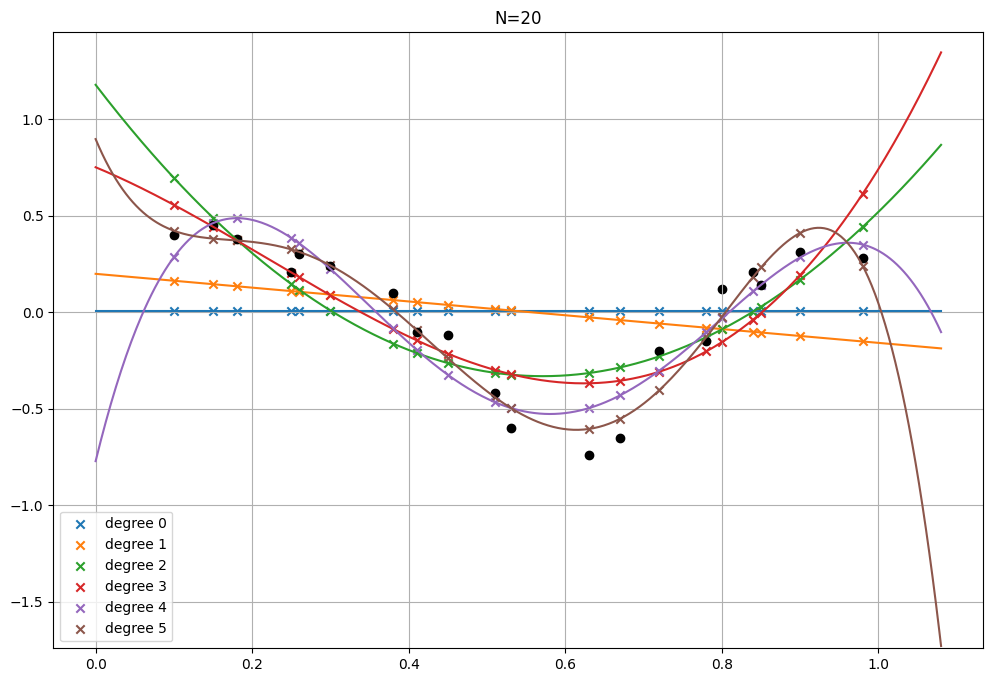

In [19]:
# START TODO ################
# Build a function: Given data, labels and degree of the polynomial
# create and fit the predictor, predict the data, print the MSE and plot
# the polynomials and data.
# Run the function on a suitable set of inputs.
# If your plot gets too zoomed out, use plt.ylim([ymin, ymax]) with suitable
# limits to constrain the y-axis.

def polynomial_reg_plot(x, t, m):

    predictor = PolyLinearRegression(m)
    predictor.fit(x, t)
    
    # predict targets y and scatterplot them
    y = predictor.predict(x)  # shape (n_datapoints)
    plt.scatter(x, y, label="degree %d" % m, c=get_color(m), marker="x")
    
    # calculate mean squared error
    mse = np.mean((t - y)**2)
    print(f"MSE for m={m}: {mse:.5f}")
    
    # create a range of inputs, predict targets and plot the polynomial
    border = 0.1
    x_min, x_max = np.min(x) - border, np.max(x) + border
    x_range = np.linspace(x_min, x_max, 500)
    
    y_range = predictor.predict(x_range)
    
    plt.plot(x_range, y_range, c=get_color(m))

plt.figure(figsize=(12, 8))
plt.title(f"N={x.shape[0]}")
for i in range(0, 6):
    polynomial_reg_plot(x, t, i)
plt.scatter(x, t, c="black")
plt.ylim(t.min() - 1, t.max() + 1)
plt.legend()
plt.grid()
plt.show()

# END TODO ################



## $\star$ $\star$ Part 2: Ridge regression

### Part 2.1: Ridge Regression using sklearn

Estimate the weights using the MAP estimator with the Gaussian prior
from this class (Ridge Regression). Use class `Ridge` from sklearn as the predictor.

Note the difference between Regularized Least Squares [1] used by sklearn's `Ridge` class with parameter $\lambda$ and Bayesian Linear Regression with a zero-mean isotropic Gaussian prior [2] as used in the slides with parameters $\alpha$ and $\beta$. The resulting weights and the mean predictions are equivalent for $\lambda = \alpha\ /\ \beta$. Parameter $\beta$ is a prior for the precision of the prediction.

Create the function `reg_ridge_sci` with parameters `x, y, t, alpha=0.001, beta=10` and create the predictor with `lambda = alpha / beta` and `Ridge(alpha=lambd, solver="svd", fit_intercept=False)`. We can set `fit_intercept=False` since the polynomial with degree 0 will act as the intercept.

To use this predictor, **either** reuse the function `get_poly_features` from above to create the polynomial input features for the Ridge model **or** create a pipeline: `make_pipeline(PolynomialFeatures(degree=m), Ridge(...))`. Note that in the second case you will need to expand the inputs `expa_x = x[:, None]` since sklearn expects inputs of shape `(n_datapoints, d_features)` even if `d_features == 1`.

- Print the MSE.
- Plot the true labels and the predictions. 
- Create a suitable input range and predict its targets to plot the polynomial line.
- **Bonus**: Compute the standard deviation for a plot in the style of slide 15. Compute the inverse posterior covariance $S_N$ given the data (slide 11). Now, compute the prediction variance for the input range (eqn. 3, slide 14). This can be tricky in numpy. Given matrices `A` and `B` both of shape `(N, D)`, to get the `N` dot products you can use `np.einsum("nd,nd->n", A, B)`. Alternatively, use slow for-loops. Compute standard deviation as square root of variance. Use `plt.fill_between` and set the transparency `alpha=0.2` to plot the standard deviation. Use `plt.ylim` to constrain the plot within `np.min(t) - 1, np.max(t) + 1`.

See what happens as you use fewer and fewer points to estimate the weights.

Also see what happens as you change the hyperparameters $\alpha$, $\beta$ and the order of the
polynomial $m$. When must it be large, when can it be chosen smaller?

- [1] Christopher M. Bishop, Pattern Recognition and Machine Learning, p. 144, eqn. 3.27
- [2] Christopher M. Bishop, Pattern Recognition and Machine Learning, p. 153, eqn. 3.55


Example output for few datapoints:

![ex5_example_output_02.png](ex5_example_output_02.png)


In [20]:
# START TODO ################
# Build the reg_ridge_sci function as described above.

def reg_ridge_sci(x, t, m, alpha=0.001, beta=10):
    # fit the predictor using our own poly features
    lambd = alpha / beta
    predictor = Ridge(alpha=lambd, solver="svd", fit_intercept=False)
    x_poly = get_poly_features(x, m)
    predictor.fit(x_poly, t)
    y = predictor.predict(x_poly)

    # compute and print error
    error = np.mean((t - y) ** 2)
    print(f"MSE for n={len(x)}, m={m}, alpha={alpha}, beta={beta}: {error:.5f}")

    # create input range
    x_border = 0.1
    x_min, x_max = np.min(x) - x_border, np.max(x) + x_border
    x_range = np.linspace(x_min, x_max, 100)
    x_range_poly = get_poly_features(x_range, m)
    y_border = 1
    y_min, y_max = np.min(t) - y_border, np.max(t) + y_border
    
    # predict targets of input range
    y_range = predictor.predict(x_range_poly)
    
    # plot
    plt.figure(figsize=(12, 8))
    plt.title(f"m={m} N={x.shape[0]} alpha={alpha} beta={beta}")
    plt.scatter(x, t, c="b", label="gt")
    plt.scatter(x, y, c="red")
    plt.plot(x_range, y_range, c="red", label=f"predictor")
    plt.ylim(y_min, y_max)

    # bonus part
    # compute the posterior covariance, slide 11
    s_n = alpha * np.eye(m + 1) + beta * (x_poly.T @ x_poly)
    # s_n shape (m + 1, m + 1)
        
    # compute the distribution's variance for the input range, slide 14
    part = x_range_poly @ np.linalg.inv(s_n)  # shape (n_datapoints, m + 1)
    # if we would do part @ x_range_poly, we would get a (n, n) result, where the
    # diagonal is what we wanted to compute.
    # einsum directly creates the result in shape (n) and is more efficient.
    var = 1 / beta + np.einsum("nd,nd->n", part, x_range_poly) 
    stddev = np.sqrt(var)
    
    n_std = 1
    plt.fill_between(x_range, y_range-n_std*stddev, y_range+n_std*stddev, color='red', alpha=0.2)
    
    # show the plot
    plt.grid()
    plt.legend()
    plt.show()

# END TODO ################


#### Varying polynomial degree $m$

MSE for n=20, m=0, alpha=0.001, beta=10: 0.12767


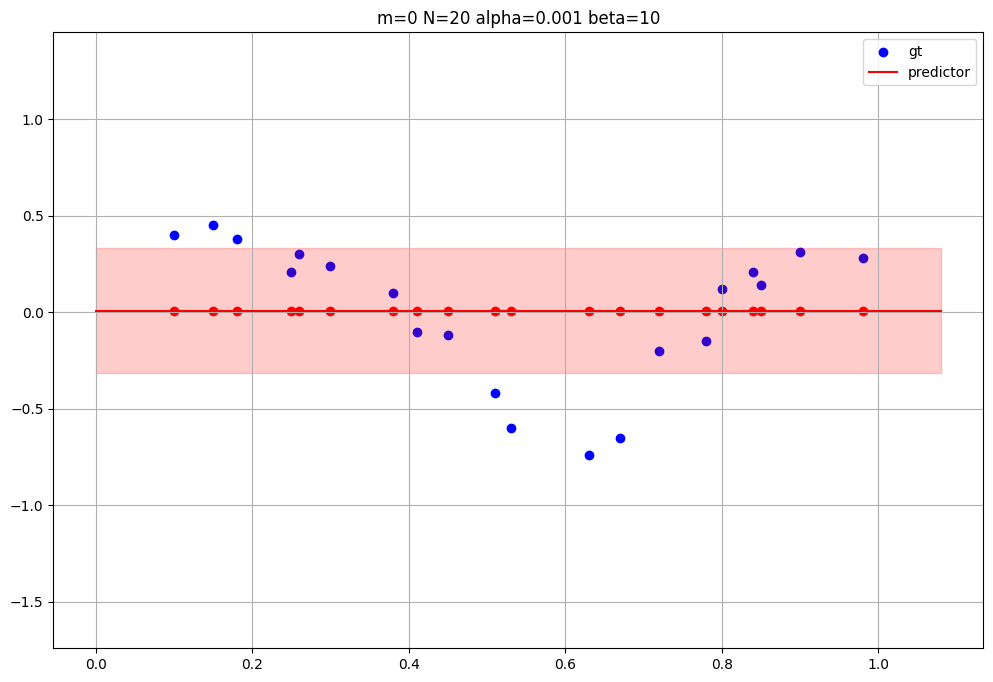

MSE for n=20, m=1, alpha=0.001, beta=10: 0.11847


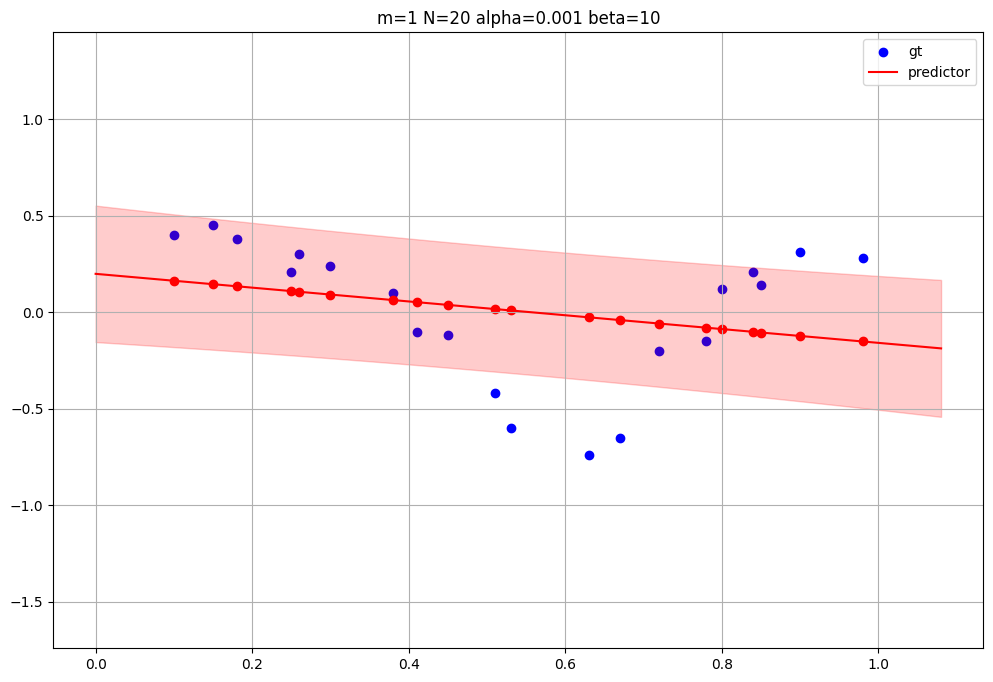

MSE for n=20, m=2, alpha=0.001, beta=10: 0.04144


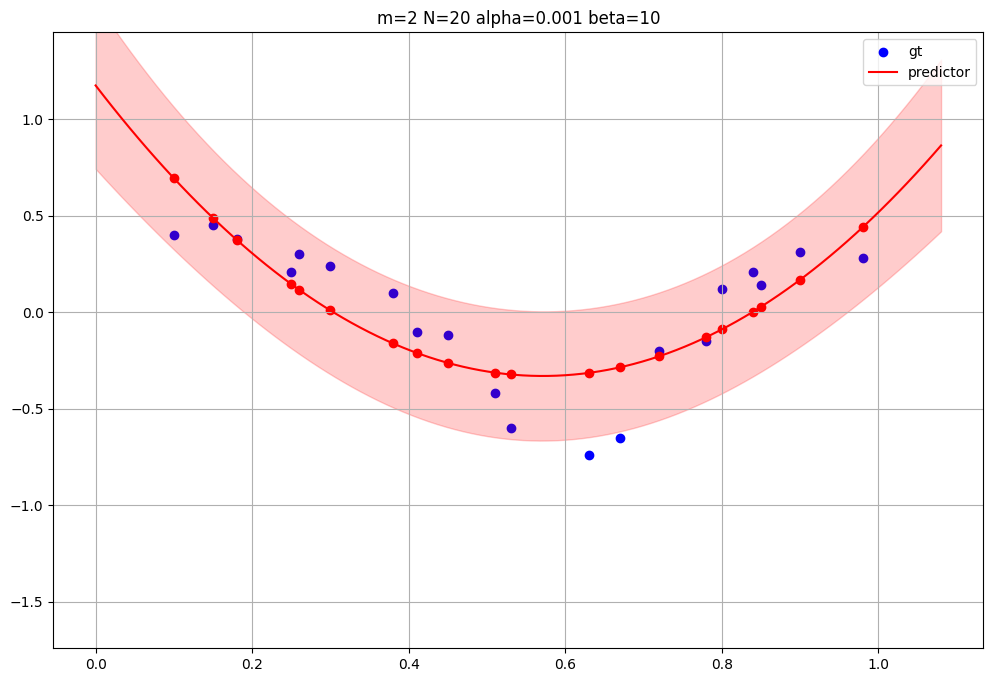

MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


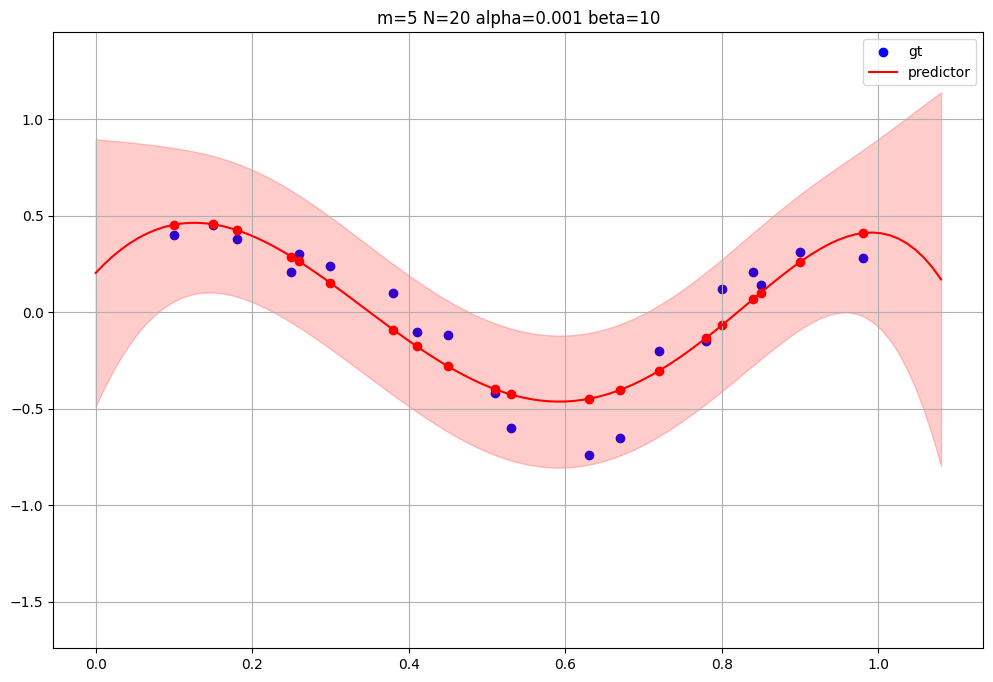

MSE for n=20, m=20, alpha=0.001, beta=10: 0.00715


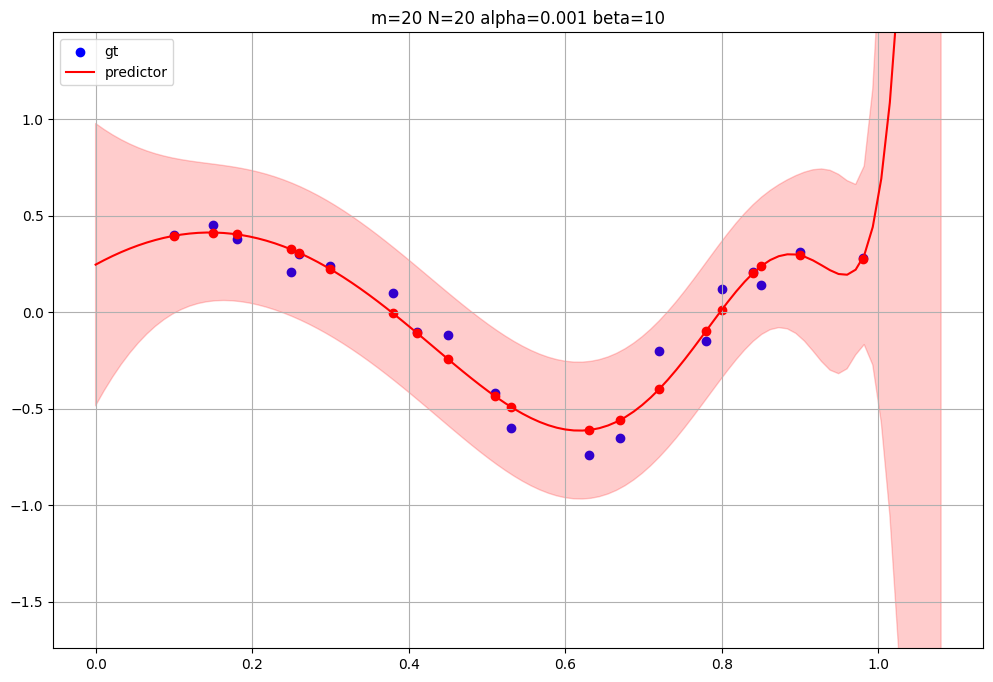

In [7]:
# START TODO ################
# Run the regression multiple times with varying polynomial degree m.
# What do you observe?

for m in [0, 1, 2, 5, 20]:  
    reg_ridge_sci(x, t, m)

# Observation: For low m, the function is not powerful enough to approximate the data.
# For high m, the function overfits and will not predict well on new data.
# END TODO ################


#### Varying dataset size $N$

MSE for n=1, m=5, alpha=0.001, beta=10: 0.00000


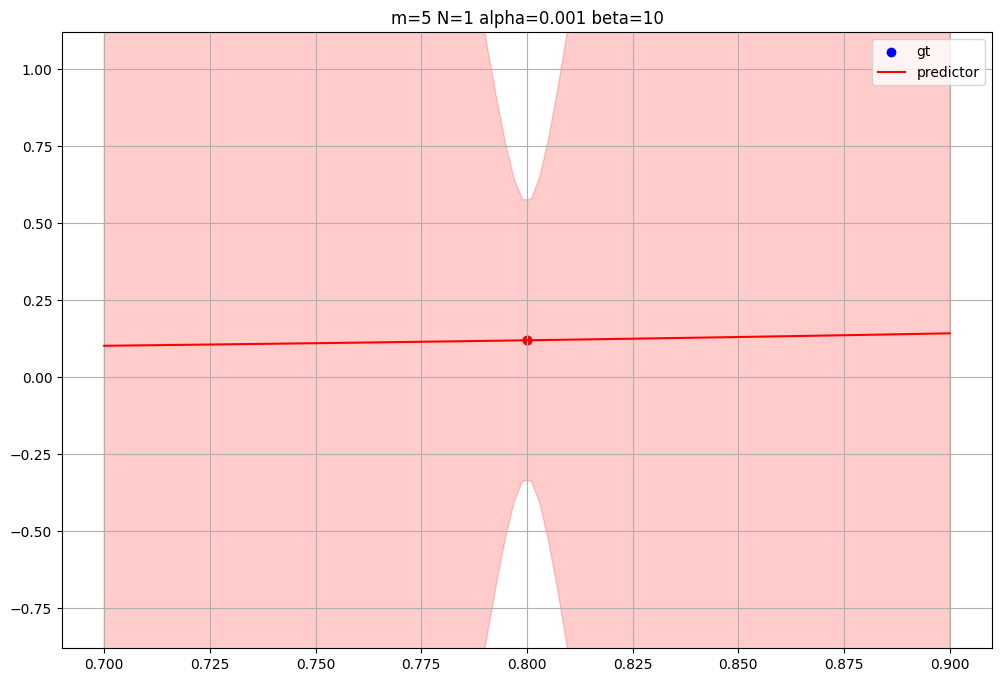

MSE for n=2, m=5, alpha=0.001, beta=10: 0.00000


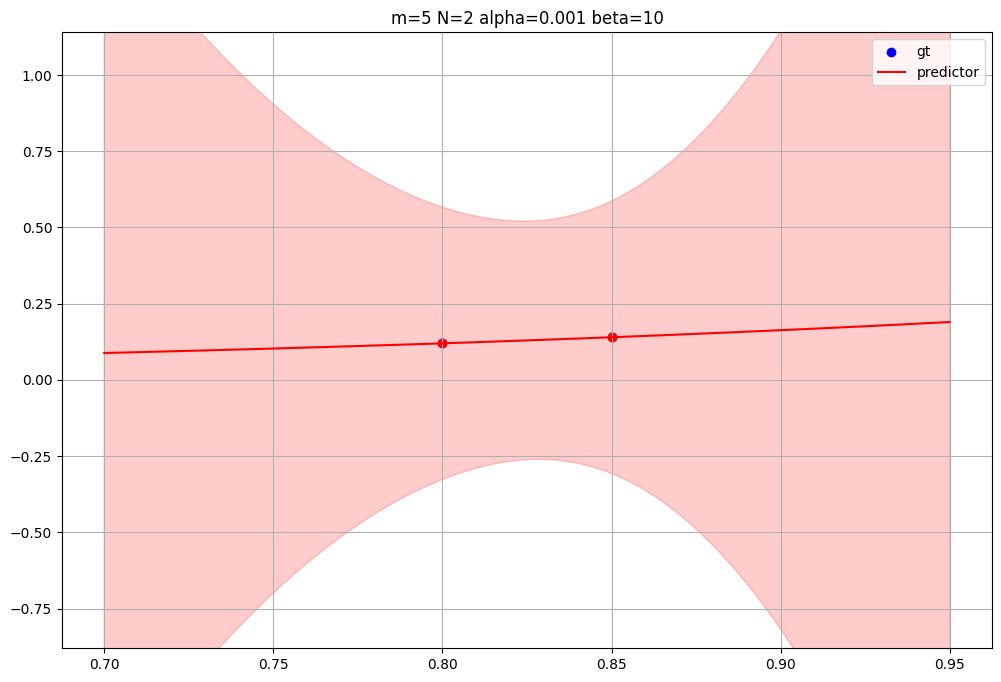

MSE for n=5, m=5, alpha=0.001, beta=10: 0.00150


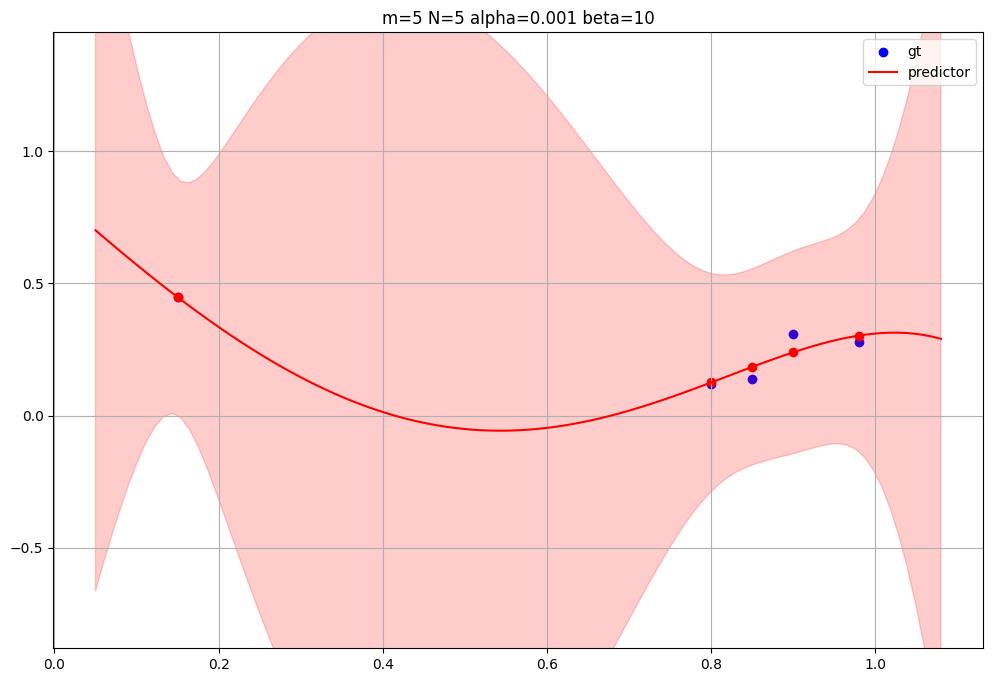

MSE for n=10, m=5, alpha=0.001, beta=10: 0.01782


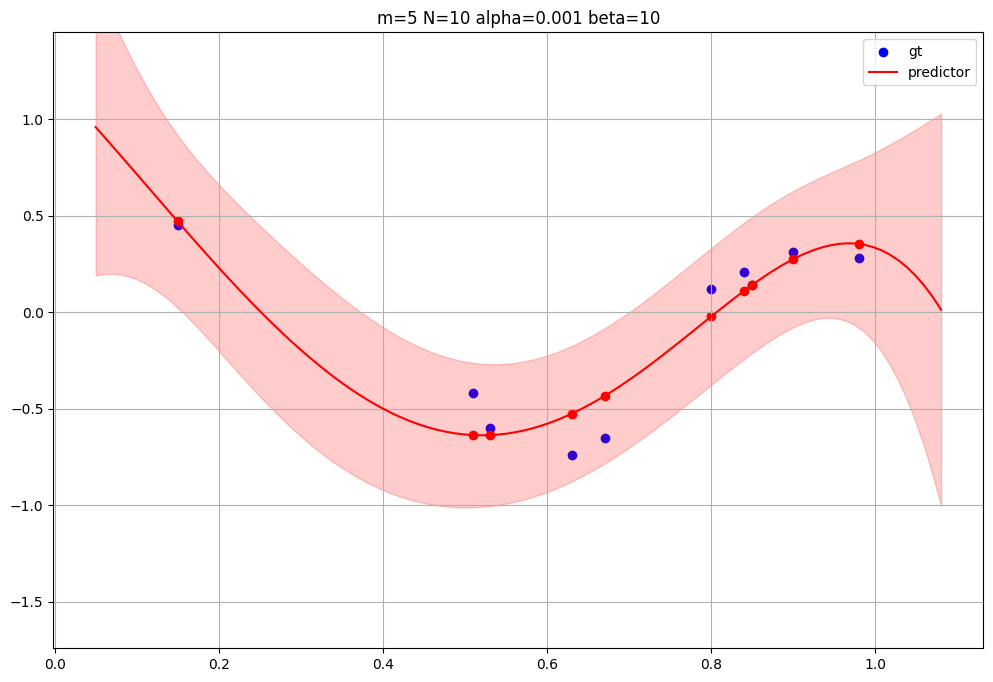

MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


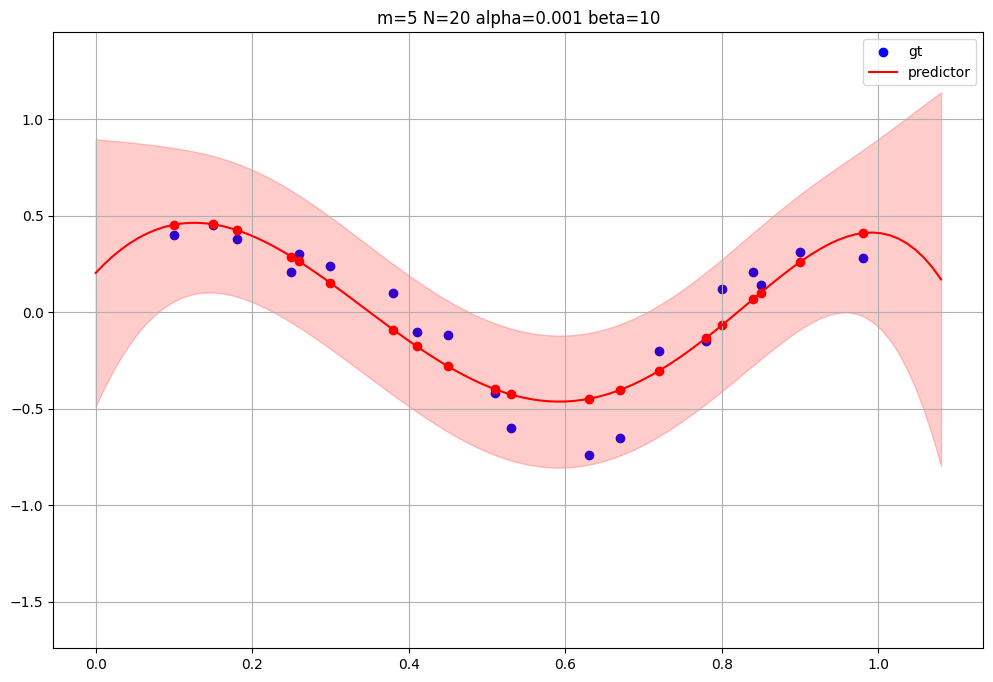

In [8]:
# START TODO ################
# Fix m=5 and run the regression multiple times,
# this time varying the amount of data.
# What do you observe?

data_amount = [1, 2, 5, 10, 20]
for n in data_amount:
    x_less = x[:n]
    t_less = t[:n]
    reg_ridge_sci(x_less, t_less, 5)

# Observation: Uncertainty reduces around datapoints.
# END TODO ################


#### Varying $\alpha$


MSE for n=20, m=5, alpha=1e-05, beta=10: 0.00975


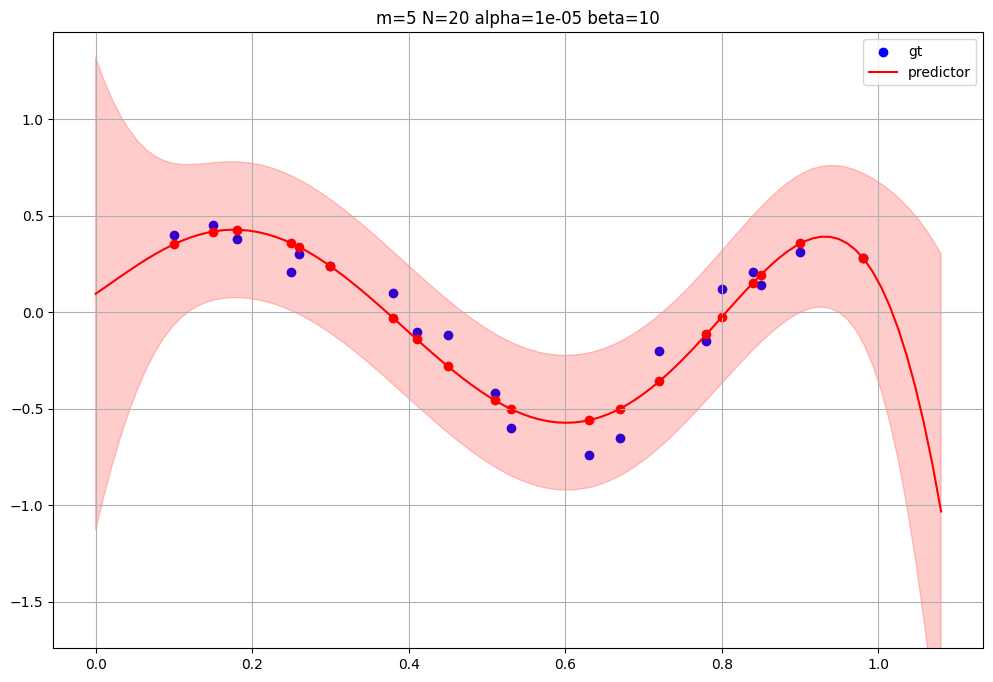

MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


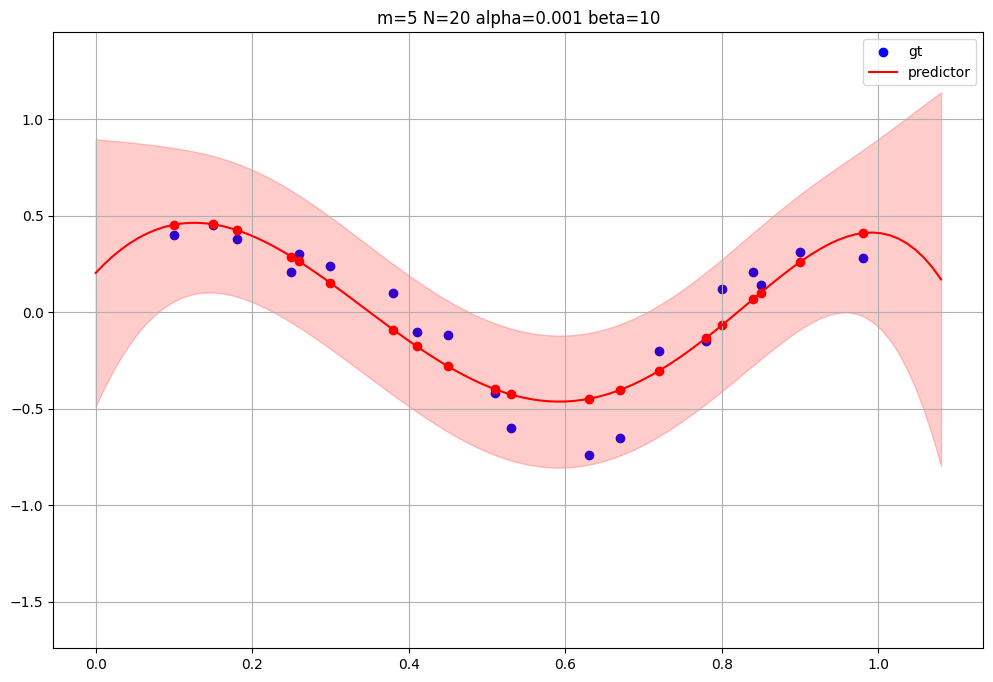

MSE for n=20, m=5, alpha=0.1, beta=10: 0.03828


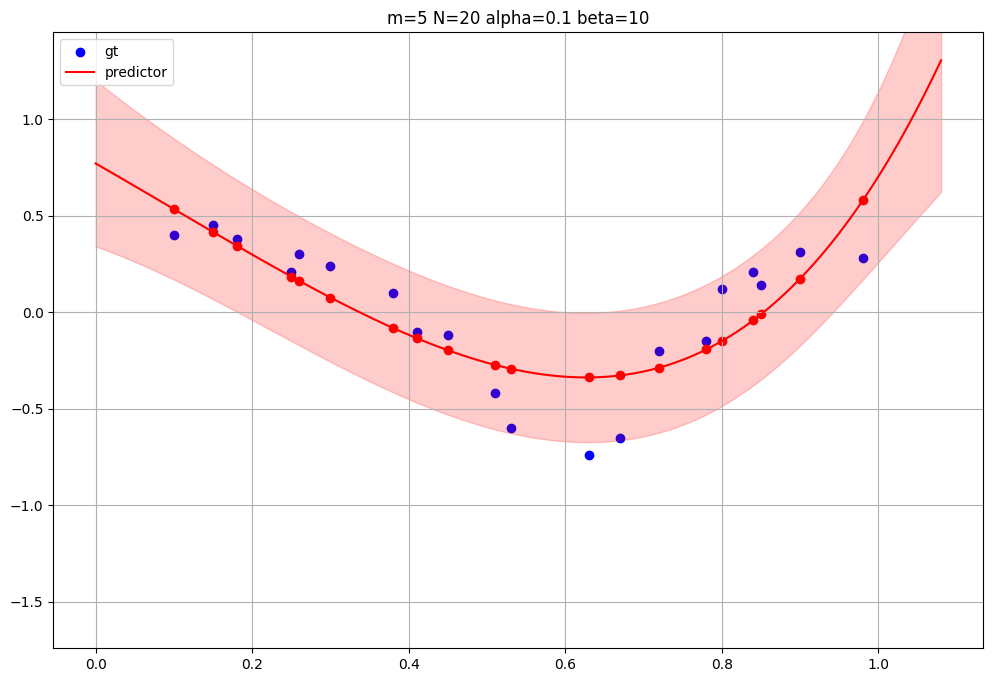

MSE for n=20, m=5, alpha=10, beta=10: 0.09711


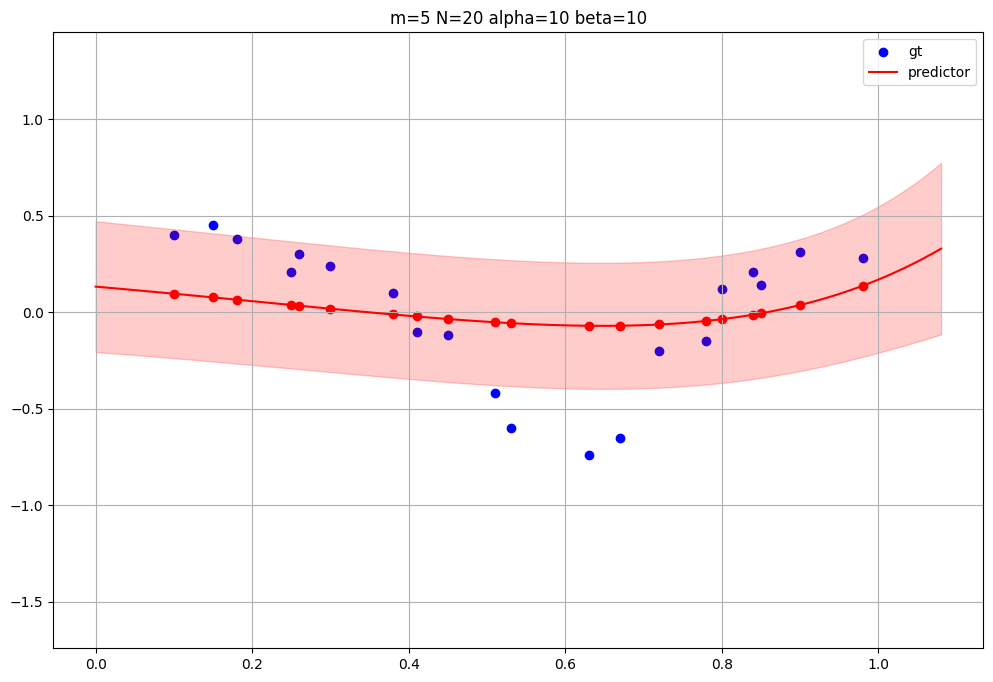

In [9]:
# START TODO ################
# Vary alpha. What do you observe?

alphas = [0.00001, 0.001, 0.1, 10]
m = 5
for alpha in alphas:
    model = reg_ridge_sci(x, t, m, alpha=alpha)

# Observation: Higher alpha leads to more regularization, more bias,
# less variance, less overfitting.
# END TODO ################


#### Varying $\beta$



MSE for n=20, m=5, alpha=0.001, beta=0.1: 0.03828


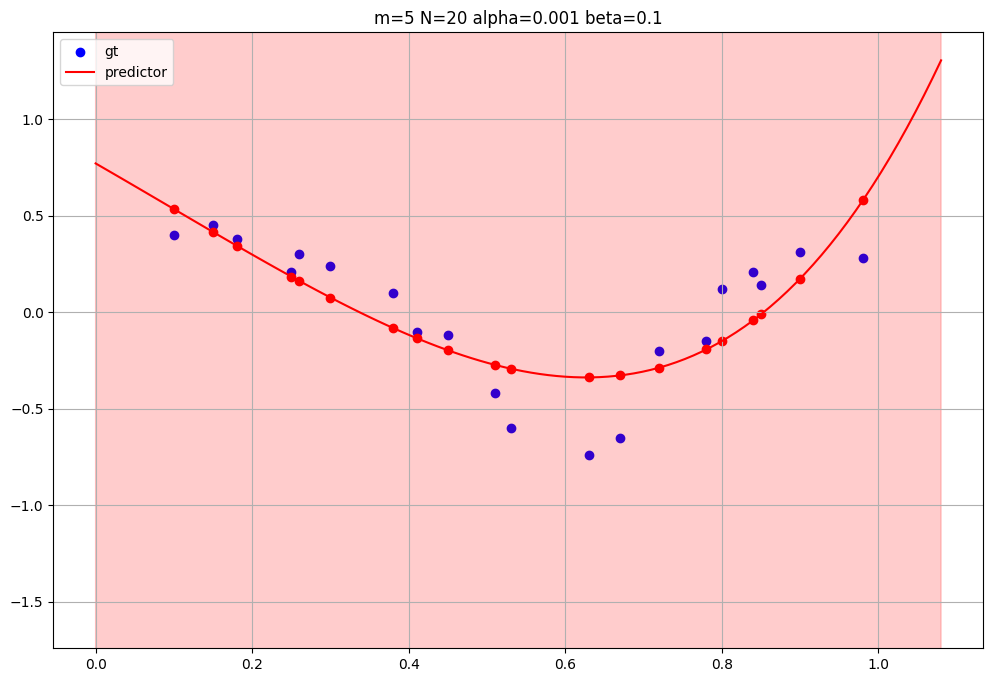

MSE for n=20, m=5, alpha=0.001, beta=1: 0.03221


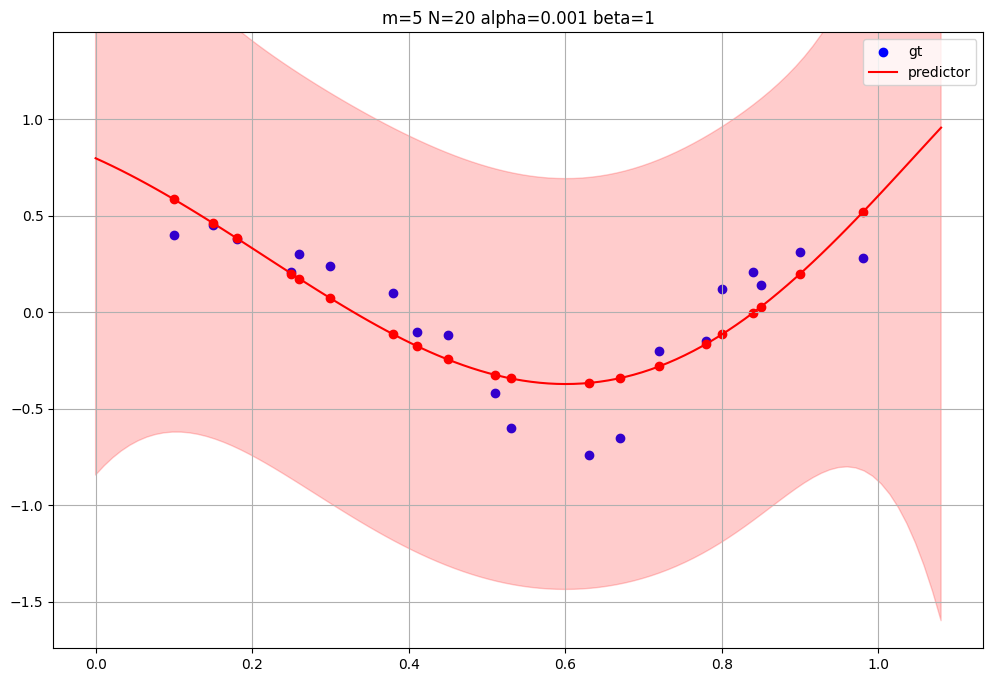

MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


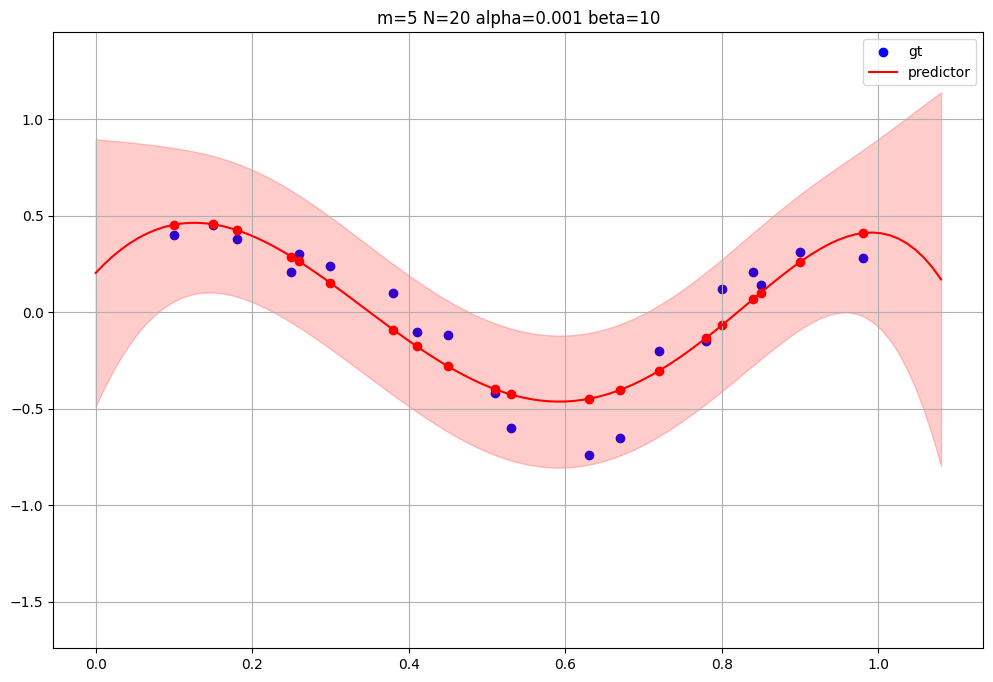

MSE for n=20, m=5, alpha=0.001, beta=100: 0.01217


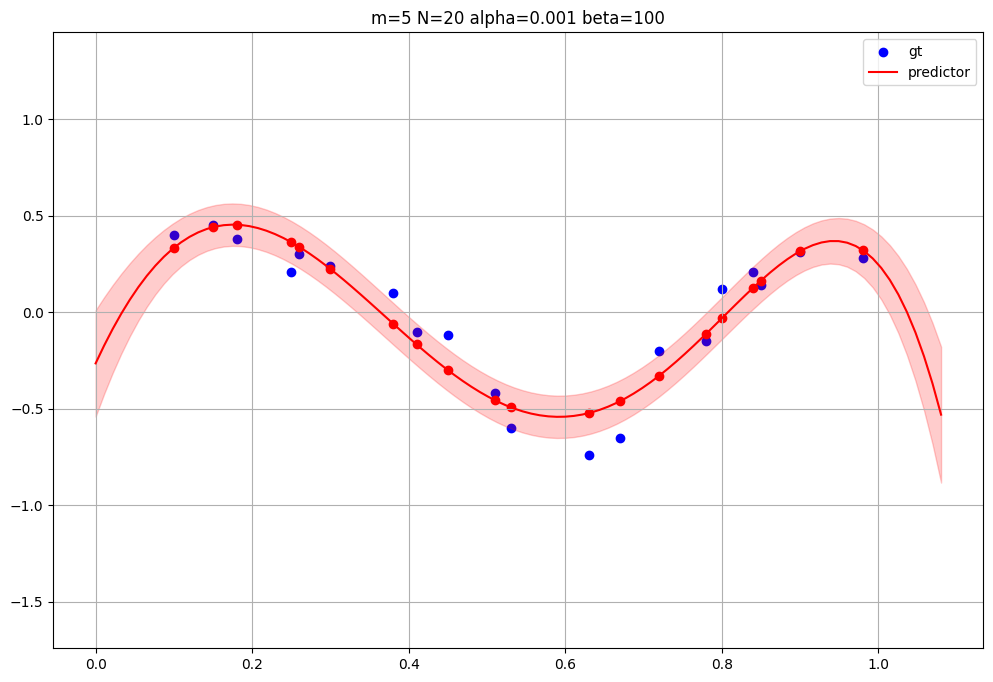

In [10]:
# START TODO ################
# Vary beta. What do you observe?

betas = [0.1, 1, 10, 100]
for beta in betas:
    model = reg_ridge_sci(x, t, 5, beta=beta)

# With a higher beta the model is more certain about its predictions:
# less bias, higher variance, more overfitting.
# END TODO ################

#### Fixing $\lambda = \alpha\ /\ \beta$ and varying their scale.



MSE for n=20, m=5, alpha=1e-05, beta=0.1: 0.01759


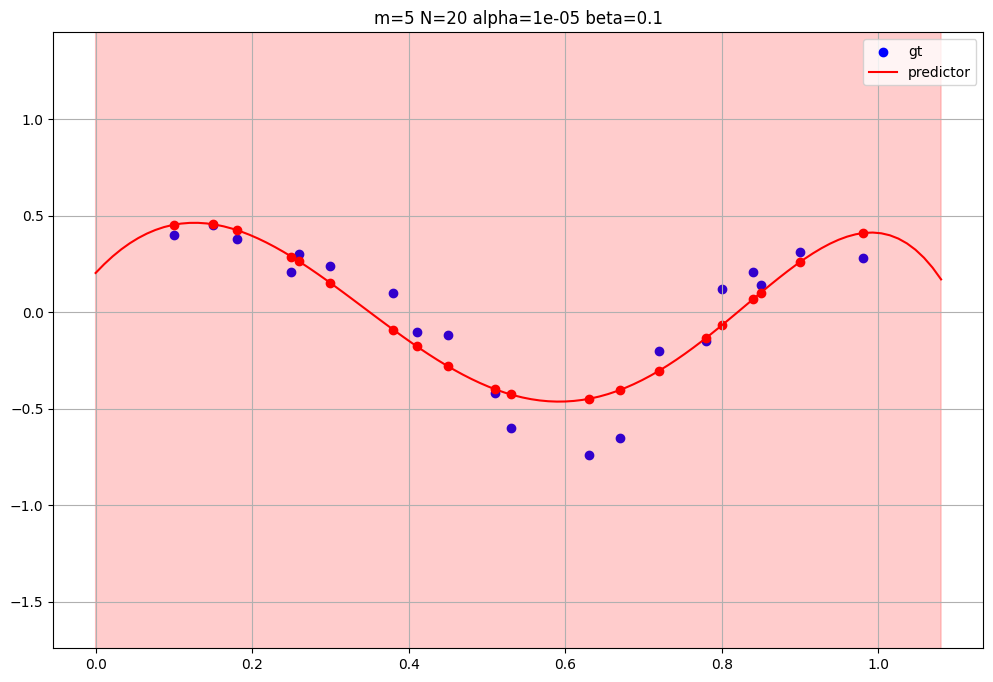

MSE for n=20, m=5, alpha=0.0001, beta=1.0: 0.01759


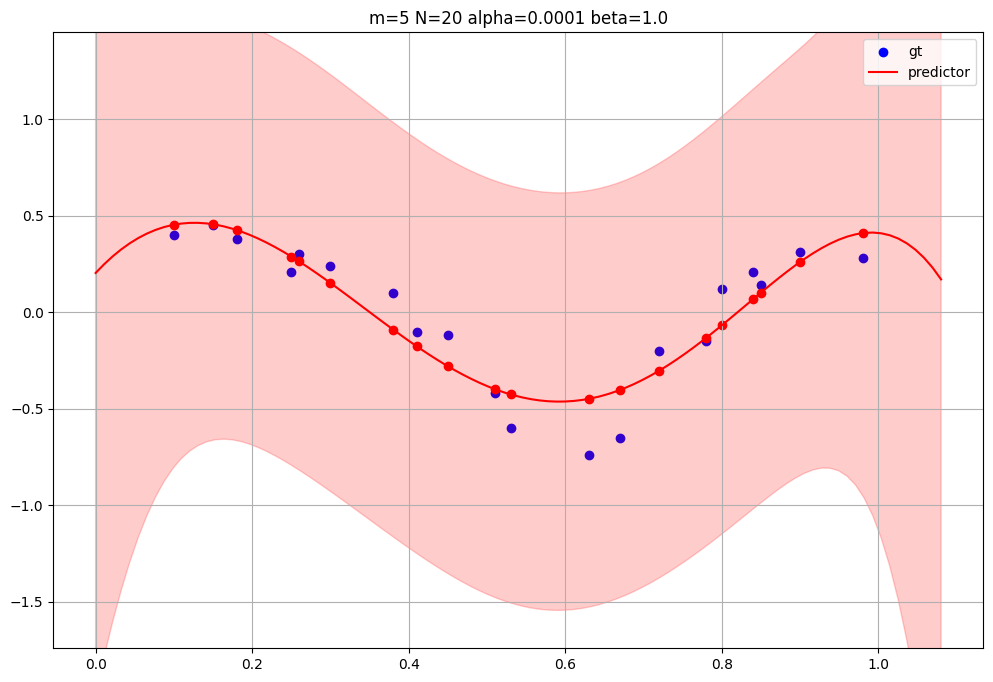

MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


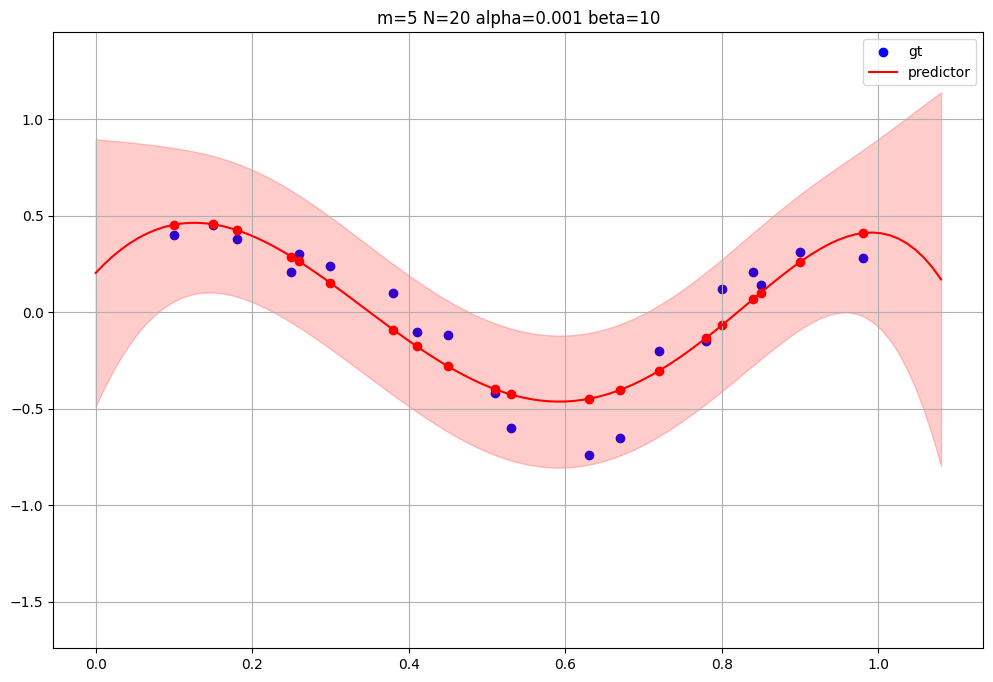

MSE for n=20, m=5, alpha=0.01, beta=100: 0.01759


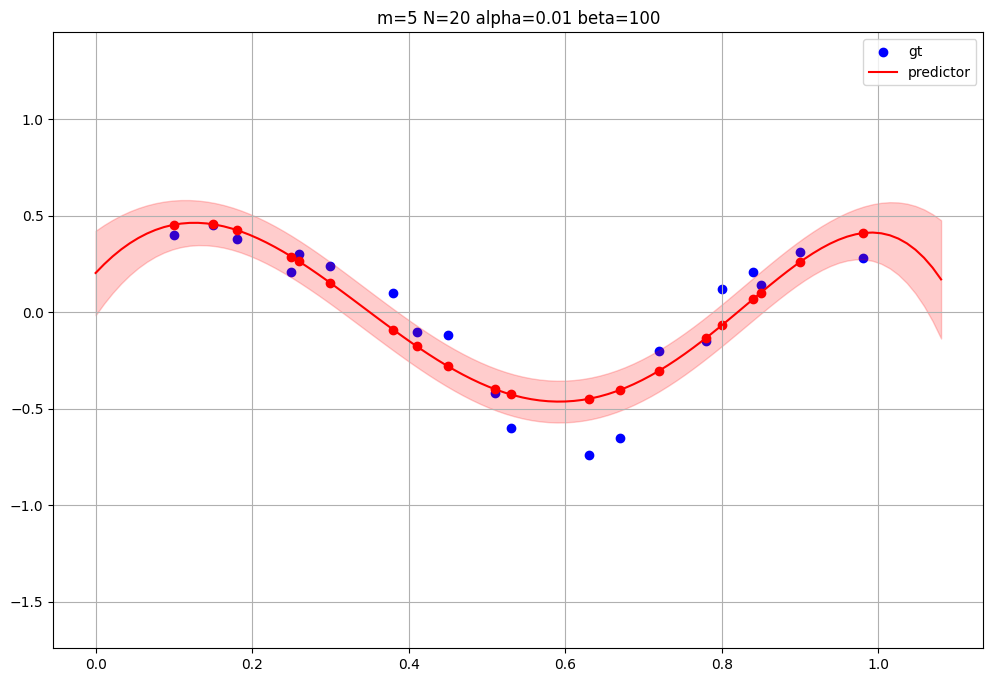

MSE for n=20, m=5, alpha=0.1, beta=1000: 0.01759


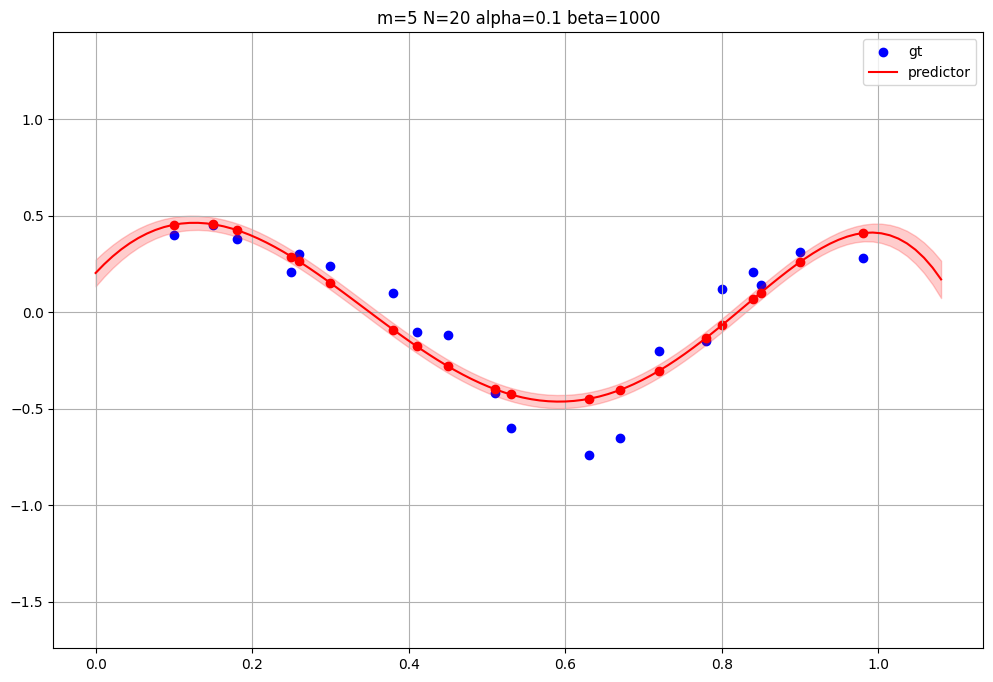

In [11]:
# START TODO ################
# Multiply both alpha and beta by the same varying constant.
# What do you observe?
mults = [0.01, 0.1, 1, 10, 100]
for mult in mults:
    model = reg_ridge_sci(x, t, 5, alpha=0.001 * mult, beta=10 * mult)

# Observation: With a fixed lambda, the mean prediction stays the same.
# The variance decreases due to the higher beta.
# END TODO ################


### Part 2.2: Manual Ridge Regression

Create the class `PolyRidgeRegression` to replace sklearn's `Ridge`, see slides "Bayesian Regression" and "Posterior distribution" for the formulae.

Create a plot as in 2.2 and verify that the results match.


In [12]:
# START TODO ################
# class PolyRidgeRegression:
class PolyRidgeRegression:
    def __init__(self, m, alpha, beta):
        self.m = m
        self.alpha = alpha
        self.beta = beta
        
    def fit(self, x, t):
        phi = get_poly_features(x, self.m)
        self.S_N = self.alpha * np.eye(self.m + 1) + self.beta * phi.T @ phi
        self.m_N = self.beta * np.linalg.inv(self.S_N) @ phi.T @ t
    
    def predict(self, x):
        phi = get_poly_features(x, self.m)
        y = self.m_N.T @ phi.T
        return y

# END TODO ################


MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


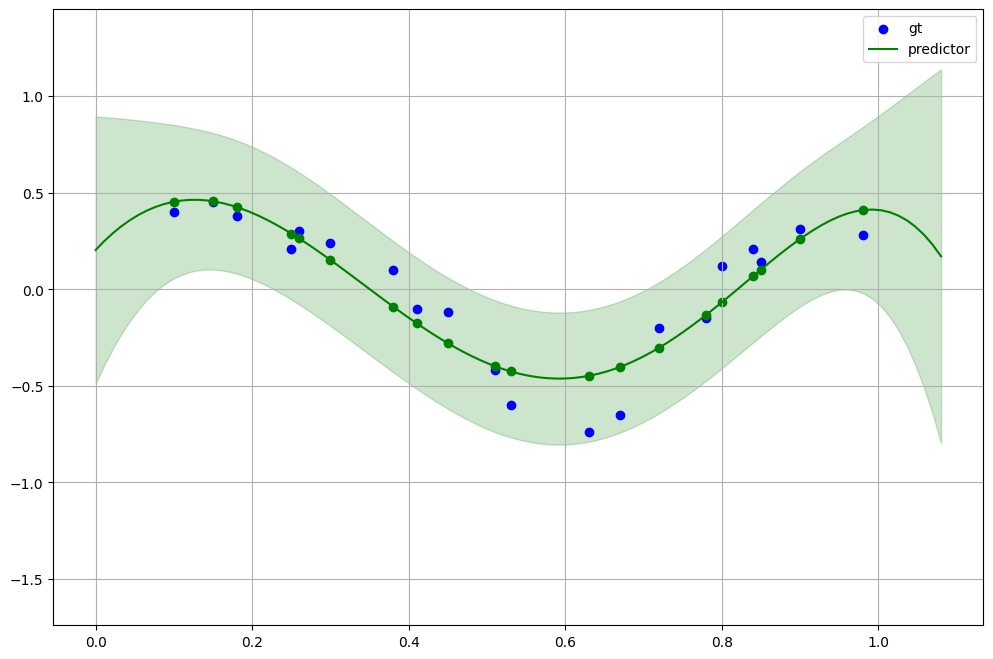

MSE for n=20, m=5, alpha=0.001, beta=10: 0.01759


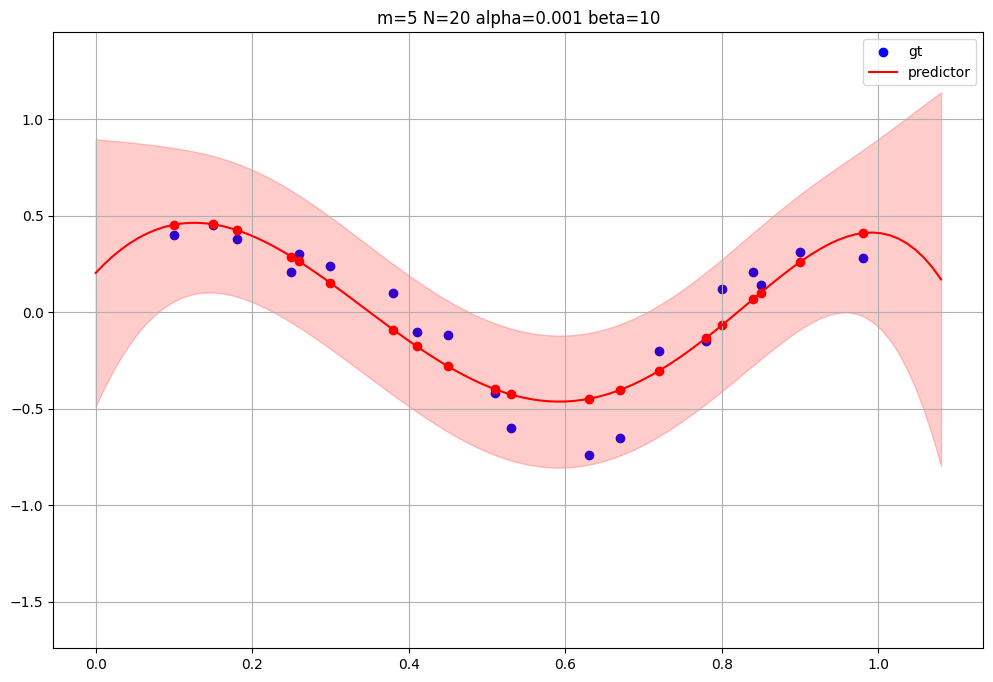

In [13]:
# START TODO ################
# def reg_ridge_own(x, t, m, alpha=0.001, beta=10):
def reg_ridge_own(x, t, m, alpha=0.001, beta=10):
    phi = get_poly_features(x, m)
    
    predictor = PolyRidgeRegression(m, alpha, beta)
    predictor.fit(x, t)
    y = predictor.predict(x)
    
    error = np.mean((t - y) ** 2)
    print(f"MSE for n={len(x)}, m={m}, alpha={alpha}, beta={beta}: {error:.5f}")

    # create input range
    x_border = 0.1
    x_min, x_max = np.min(x) - x_border, np.max(x) + x_border
    x_range = np.linspace(x_min, x_max, 100)
    y_border = 1
    y_min, y_max = np.min(t) - y_border, np.max(t) + y_border
    
    # predict targets of input range
    y_range = predictor.predict(x_range)

    # bonus part to plot the variance, see function reg_ridge_sci for details
    x_range_poly = get_poly_features(x_range, m)
    part = x_range_poly @ np.linalg.inv(predictor.S_N)
    var = 1 / beta + np.einsum("nd,nd->n", part, x_range_poly) 
    stddev = np.sqrt(var)
    n_std = 1
        
    plt.figure(figsize=(12, 8))
    plt.fill_between(x_range, y_range-n_std*stddev, y_range+n_std*stddev, color='g', alpha=0.2)
    plt.scatter(x, t, c="b", label="gt")
    plt.scatter(x, y, c="g")
    plt.plot(x_range, y_range, c="g", label=f"predictor")
    plt.ylim(y_min, y_max)
    plt.grid()
    plt.legend()
    plt.show()

# END TODO ################

# here we verify that the two functions produce the same plot and MSE
reg_ridge_own(x, t, 5, alpha=0.001, beta=10)
reg_ridge_sci(x, t, 5, alpha=0.001, beta=10)


## $\star \star \star$ Part 3: Hyperparameter optimization with EM

Find the optimum hyperparameters using the evidence approximation. 
It is not that hard. You know EM and you know how to
estimate the weight parameters. Just combine these two. 

See slide 24 and Bishop 3.5.1 pages 166-169, especially eqn. 3.95.

Start the optimization with $\alpha_0=0.001, \beta_0=10$.
Create two plots using function `reg_ridge_sci` from question 2, one with the old hyperparameters and one with the optimized hyperparameters. The MSE should be lower in the second case because you have found better hyper-parameters.

Verify your results by fitting a `BayesianRidge` predictor from sklearn. The parameters are named differently: Create it as `BayesianRidge(lambda_init=alpha0, alpha_init=beta0, fit_intercept=False, verbose=True)`, fit and extract the results as `alpha = br.lambda_` and `beta = br.alpha_`. You should receive the same hyperparameters as in your own evidence approximation.


0 a = 0.0036492519584921104 b = 43.951761759011774
1 a = 0.003144832030115981 b = 46.3992370191232
2 a = 0.00272081188313802 b = 48.971567609951286
3 a = 0.0024007762390092884 b = 51.30489769029461
4 a = 0.0021814835084316953 b = 53.120759171903416
5 a = 0.0020423823440969126 b = 54.361640625119875
6 a = 0.001958878357097803 b = 55.13551810162253
7 a = 0.0019105154634894827 b = 55.591926988072935
8 a = 0.0018831098147242006 b = 55.85276481946143
9 a = 0.0018677762951066672 b = 55.999299878661475
10 a = 0.0018592589885962404 b = 56.08086102115002
11 a = 0.0018545470188794215 b = 56.12602977505414
12 a = 0.0018519461152779121 b = 56.150975745855945
13 a = 0.0018505122626178265 b = 56.16473231283679
14 a = 0.0018497223376229544 b = 56.17231218168054
15 a = 0.001849287324552127 b = 56.176486797857415
16 a = 0.0018490478121289886 b = 56.178785397561356
17 a = 0.0018489159550030177 b = 56.18005086353407
18 a = 0.0018488433691638978 b = 56.18074749827076
19 a = 0.001848803412910888 b = 56.181

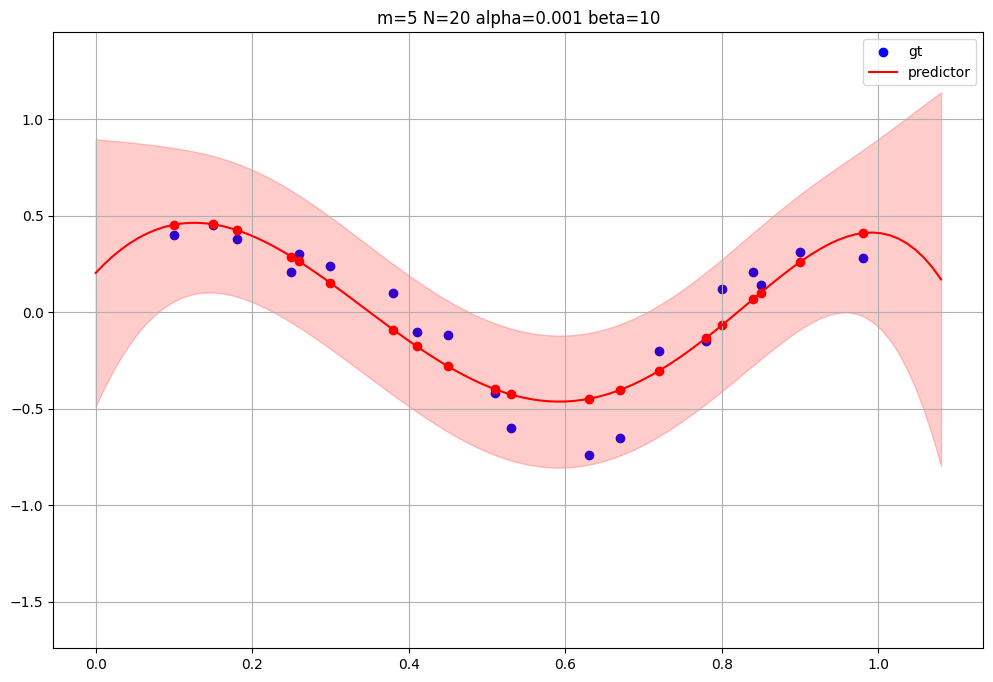

MSE for n=20, m=5, alpha=0.001848803412910888, beta=56.18113097717294: 0.01353


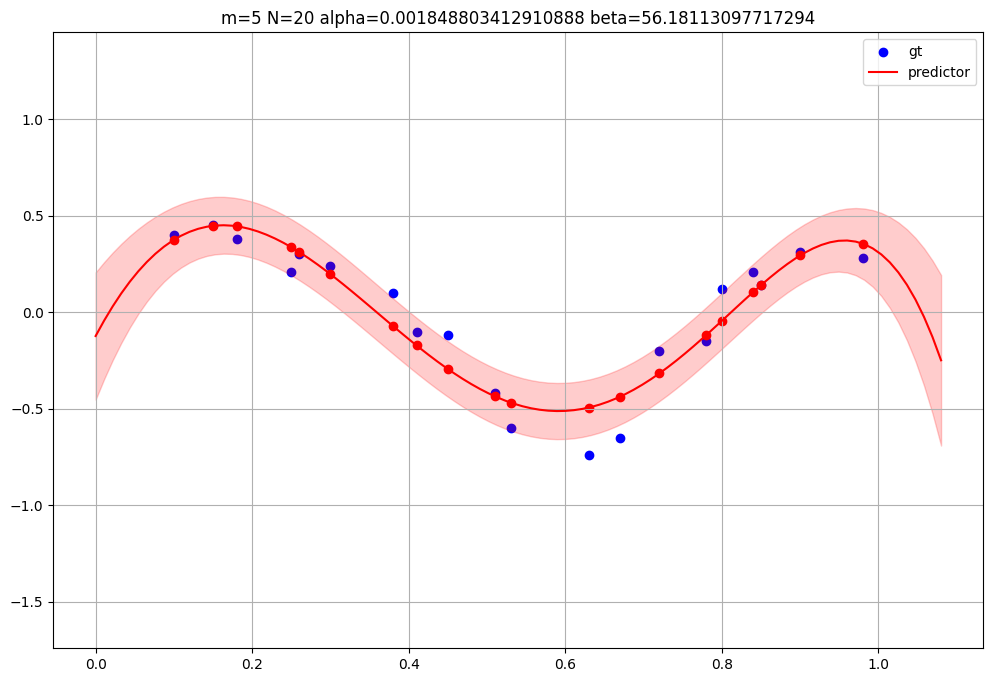

In [14]:
# START TODO ################
# class EvidenceApproximator:
class EvidenceApproximator:
    def __init__(self, m, alpha0=0.001, beta0=1, iter_steps=20):
        self.m = m
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.iter_steps = iter_steps
        
    def run_em(self, x, t):
        x_poly = get_poly_features(x, self.m)
        n = len(x)
        alpha = self.alpha0
        beta = self.beta0
        
        for i in range(self.iter_steps):
            m_N = self.e_step(x_poly, t, alpha, beta)
            alpha, beta = self.m_step(x_poly, t, m_N, alpha, beta)
            print(i, "a =", alpha, "b =",beta)
        print()
        return alpha, beta
        
    def e_step(self, x_poly, t, alpha, beta):
        S_N = alpha * np.eye(self.m + 1) + beta * x_poly.T @ x_poly  # slide 11 eqn. 4
        m_N = beta * np.linalg.inv(S_N) @ x_poly.T @ t  # slide 11 eqn. 3
        return m_N
        
    def m_step(self, x_poly, t, m_N, alpha_old, beta_old):
        # slide 24
        eigvals = np.linalg.eigvals(beta_old * x_poly.T @ x_poly)
        gamma = np.sum(eigvals / (eigvals + alpha_old))
        alpha_new =  gamma / (m_N.T @ m_N)
        
        N = len(x_poly)
        beta_new_inv = 1 / (N - gamma) * np.sum( (t - m_N.T @ x_poly.T) ** 2)
        beta_new = beta_new_inv ** -1

        return alpha_new, beta_new

# END TODO ################

m = 5
alpha = 0.001
beta = 10
ea = EvidenceApproximator(m, alpha0=alpha, beta0=beta, iter_steps=20)
new_alpha, new_beta = ea.run_em(x, t)

# plot results
reg_ridge_sci(x, t, m, alpha=alpha, beta=beta)
reg_ridge_sci(x, t, m, alpha=new_alpha, beta=new_beta)


Convergence after  20  iterations
alpha: 0.0018487954000298143
beta: 56.18080733797258
Error (bayes) at m= 5 0.013527269027205033
MSE for n=20, m=5, alpha=0.0018487954000298143, beta=56.18080733797258: 0.01353


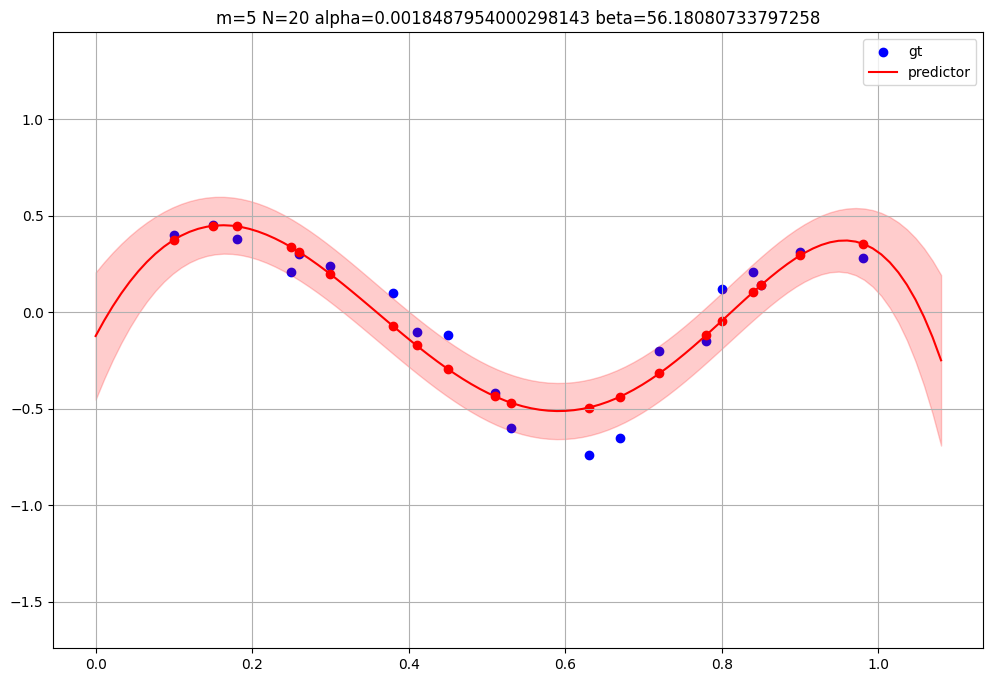

In [15]:
# START TODO ################
# Run BayesianRidge from sklearn and compare it to your own EvidenceApproximator
# def reg_ridge_bayes(x, t, m, alpha0, beta0):
def reg_ridge_bayes(x, t, m, alpha0, beta0):
    x_poly = get_poly_features(x, m)
    
    br = BayesianRidge(lambda_init=alpha0, alpha_init=beta0, fit_intercept=False, verbose=True)
        # fit_intercept=False, tol=1e-5, verbose=True)
    br.fit(x_poly, t)
    alpha = br.lambda_
    beta = br.alpha_

    print(f"alpha: {alpha}")
    print(f"beta: {beta}")
        
    y, y_std = br.predict(x_poly, return_std=True)
    error = np.mean((t - y) ** 2)
    print("Error (bayes) at m=", m, error.mean())
    
    reg_ridge_sci(x, t, m, alpha=alpha, beta=beta)

# END TODO ################

reg_ridge_bayes(x, t, 5, alpha, beta)


### Part 4: Bonus

MSE for m=19: 0.00708


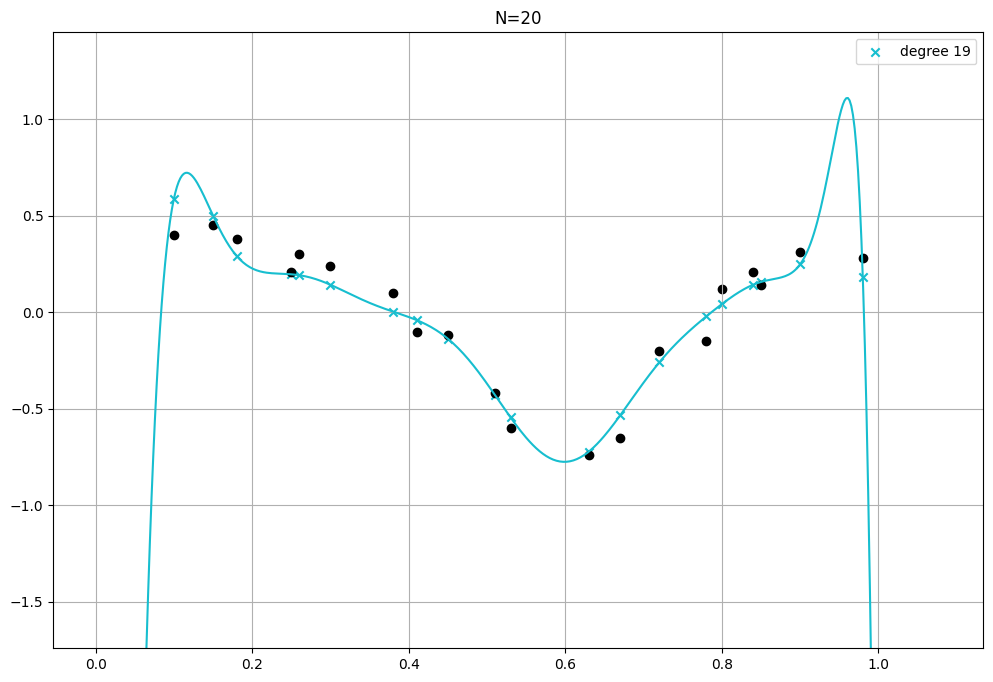

MSE for m=19: 0.00032


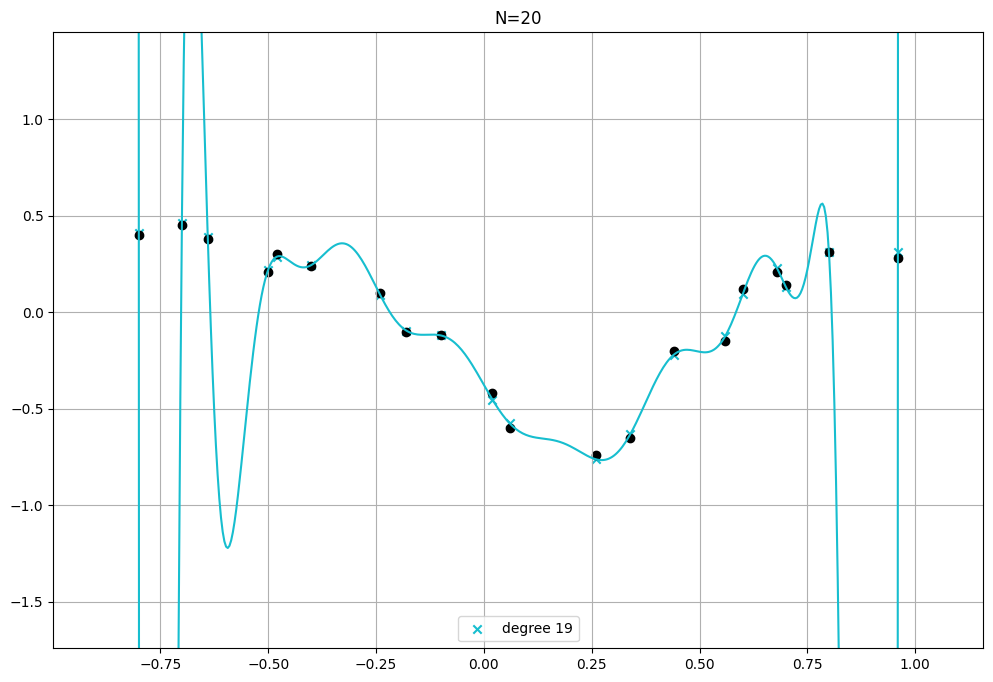

In [16]:
# START TODO ################
# Go back to the simple case in part 1, linear regression with maximum likelihood.
# Set the polynomial degree m=19 and run the regression plot again.
# What would you expect to happen?
# What actually happens?
# How to fix the problem?

# Here, numerical instabilities will make it hard to exactly overfit.
plt.figure(figsize=(12, 8))
plt.title(f"N={x.shape[0]}")
polynomial_reg_plot(x, t, 19)
plt.scatter(x, t, c="black")
plt.ylim(t.min() - 1, t.max() + 1)
plt.legend()
plt.grid()
plt.show()

# Normalizing the data solves it.
x2 = (x - 0.5) * 2
plt.figure(figsize=(12, 8))
plt.title(f"N={x.shape[0]}")
polynomial_reg_plot(x2, t, 19)
plt.scatter(x2, t, c="black")
plt.ylim(t.min() - 1, t.max() + 1)
plt.legend()
plt.grid()
plt.show()


# END TODO ################
